# <span style="color:green;">Topic Modeling</span>

### Libraries

In [1]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.stem import SnowballStemmer
from gensim.parsing.preprocessing import STOPWORDS
import re
from nltk.stem import WordNetLemmatizer
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import pickle
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

In [2]:
# for using saved files
# first uncomment following block of codes 
# then you can load the saved files

# training model
# with open('lda_model.pkl', 'rb') as f:
#    lda_ml = pickle.load(f)

### Load the dataset

In [3]:
articles1 = pd.read_csv('articles1.csv')
articles2 = pd.read_csv('articles2.csv')
articles3 = pd.read_csv('articles3.csv')

### Combining the articles

In [4]:
# Drop first column
# articles1.drop(columns=0, inplace=True)
# articles2.drop(columns=0, inplace=True)
# articles3.drop(columns=0, inplace=True)

# Concat the three articles together
combin_all = pd.concat([articles1, articles2, articles3])

# Reset index if needed
combin_all.reset_index(drop=True, inplace=True)

In [5]:
# shape 
print(combin_all.shape)
combin_all.head()

(142570, 10)


,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."


### cleaning

In [6]:
stemmer = SnowballStemmer("english")

def clean_text(text):
    # deleting the special charcters
    text = re.sub(r"[^a-zA-Z0-9']", ' ', text)
    # white space normalization
    text = re.sub(r'\s+', ' ', text)
    # apostroph correction
    text = re.sub(r"â€™", "'", text)
    text = re.sub(r"â€œ|â€ ", '"', text)
    text = re.sub(r"â€”", "-", text)
    # lowercase change
    text = text.lower()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def cleaning(txt):
    txt = clean_text(txt)
    # remove stopwords, tokenize, lowercase lemmatize
    final = []
    for tok in gensim.utils.simple_preprocess(txt):
        if tok not in gensim.parsing.preprocessing.STOPWORDS and len(tok) > 3:
            final.append(clean_text(tok))
    return final

# cleaning our content column
# combin_all['clean_content'] = combin_all['content'].apply(cleaning)
# combin_all.head()

clean_content = combin_all['content'].map(cleaning)
clean_content.head()


0    [washington, congression, republican, fear, co...
1    [bullet, shell, count, blood, dri, votiv, cand...
2    [walt, disney, bambi, open, critic, prais, spa...
3    [death, great, equal, necessarili, evenhand, f...
4    [seoul, south, korea, north, korea, leader, sa...
Name: content, dtype: object

### Preparation for LDA

In [7]:
# a dictionary for our documents
# dictionary = corpora.Dictionary(combin_all['clean_content'])
dictionary = gensim.corpora.Dictionary(clean_content)

dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n=100000)

# bag of word corpus
# corpus = [dictionary.doc2bow(doc) for doc in combin_all['clean_content']]
corpus = [dictionary.doc2bow(doc) for doc in clean_content]

### Training the model

In [8]:
# In the event that LdaMulticore encounters an error on your system, use 'lda mono core'.
# lda_ml = gensim.models.LdaModel(corpus=corpus, id2word = dictionary, num_topics = 20, passes = 50)

# lda multicore 
lda_ml = gensim.models.LdaMulticore(corpus=corpus, num_topics=20, id2word = dictionary, passes = 50, workers=2)

#### saving lda model inside of file

In [9]:
# Saving our trained lda model
with open('lda_model.pkl', 'wb') as f:
    pickle.dump(lda_ml, f)

### Creating the topic word distributions text file and saving it

In [11]:
# gaining the topic word dist 
topic_word_distributions = lda_ml.show_topics(formatted=False, num_words=20) 

# create the text file word dist => topic_word_distributions.txt
with open('topic_word_distributions.txt', 'w') as file:
    for topic, word_dist in topic_word_distributions:
        file.write(f"Topic {topic}:\n")
        for word, prob in word_dist:
            file.write(f"{word}: {prob}\n")
        file.write('\n')

In [12]:
# create another one word dist 2 => topic_word_distributions2.txt
topics_words = lda_ml.show_topics(num_topics=20, num_words=10)
with open('topic_word_distributions2.txt', 'w') as file:
    for topic, words in topics_words:
        file.write(f"Topic {topic}:\n{words}\n\n")


### Creating the document topic distributions text file and saving it

In [13]:
# gaining the document topic distributions
document_topic_distributions = lda_ml[corpus]

# create a text file doc dist => document_topic_distributions.txt
with open('document_topic_distributions.txt', 'w') as file:
    for doc_topics in document_topic_distributions:
        file.write(f"{doc_topics}\n")

In [14]:
# Get document-topic distributions
doc_topic_dist = []
for i, row_list in enumerate(lda_ml[corpus]):
    doc_topic_dist.append(row_list)

# create another doc dist => document_topic_distributions2.txt
with open('document_topic_distributions2.txt', 'w') as file:
    for doc_topics in doc_topic_dist:
        file.write(f"{doc_topics}\n")

## <span style="color:darkviolet;">PyLDAvis for visualizing</span>

In [8]:
# first preparing for visualization
vis_data = gensimvis.prepare(lda_ml, corpus, dictionary)

# then Visualizing the topics
pyLDAvis.display(vis_data)

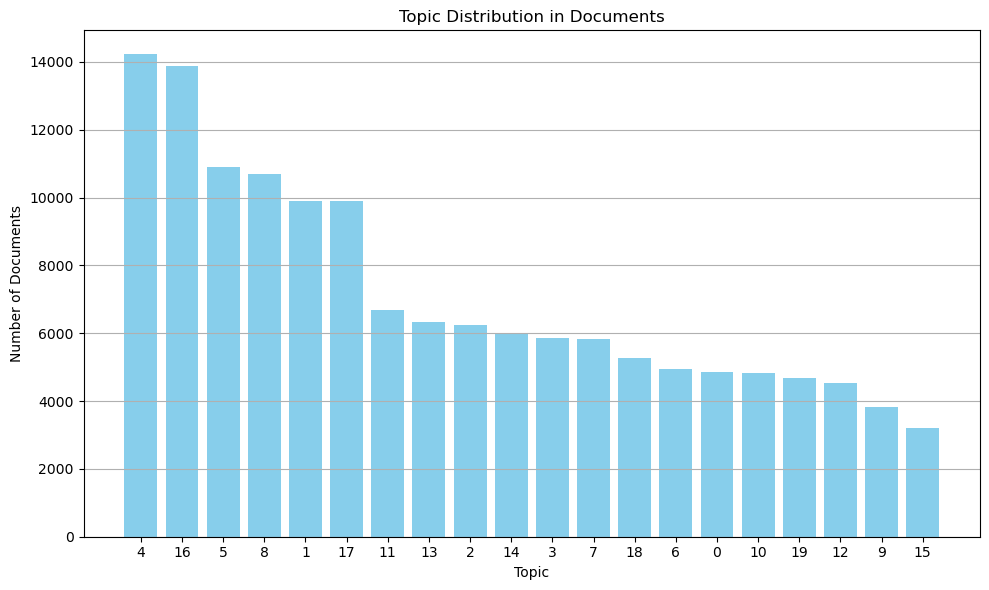

In [24]:
# popular topics
dominant_topics = []
for doc in lda_ml[corpus]:
    dominant_topic = max(doc, key=lambda x: x[1])[0]
    dominant_topics.append(dominant_topic)

# Counting them
topic_counts = {}
for topic in dominant_topics:
    if topic in topic_counts:
        topic_counts[topic] += 1
    else:
        topic_counts[topic] = 1

# Sorting the topic based on their counts
sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

topics, counts = zip(*sorted_topics)

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(topics)), sorted(counts, reverse=True), color='skyblue')  # Bars sorted by count
plt.xlabel('Topic')
plt.ylabel('Number of Documents')
plt.title('Topic Distribution in Documents')
plt.xticks(range(len(topics)), topics)
plt.grid(axis='y')  # gridlines
plt.tight_layout()
plt.show()

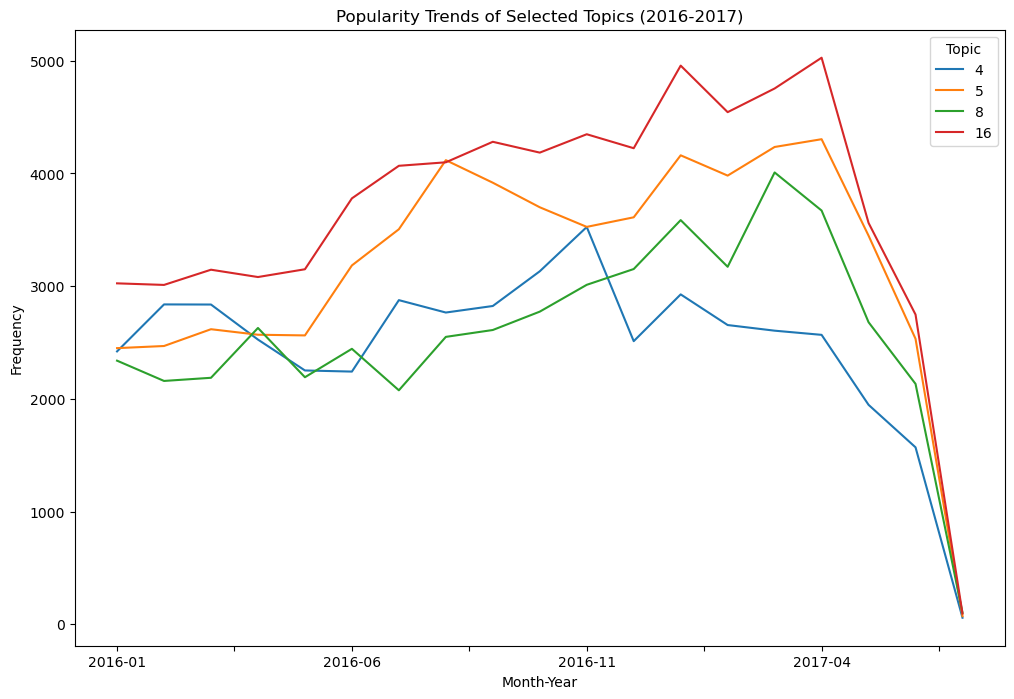

In [28]:
import warnings
warnings.filterwarnings('ignore')

# in the following I put the most popular topic based on the barchart
popular_topics = [4, 16, 5, 8]

# adding the topic distribution to our dataframe Add document topic distribution to the DataFrame
combin_all['topic_distribution'] = doc_topic_dist

# in the following I had to clean the columns of 2016 and 2017 because they have a lot of anomalies inside of them 
filtered_data = combin_all[
    combin_all['year'].apply(lambda x: isinstance(x, (int, float)) and x > 1000 and x < 9999) &
    combin_all['date'].apply(lambda x: pd.to_datetime(x, errors='coerce').year == 2016 or pd.to_datetime(x, errors='coerce').year == 2017)
].copy()

# focusing on documents that realted to popular topics 
filtered_data.loc[:, 'relevant_topics'] = filtered_data['topic_distribution'].apply(lambda x: [topic for topic, dist in x if topic in popular_topics])

# information in month and year columns 
filtered_data.loc[:, 'month_year'] = filtered_data['date'].apply(lambda x: pd.to_datetime(x, errors='coerce').strftime('%Y-%m'))

# frequency of popular topics over time
topic_counts = filtered_data.explode('relevant_topics').groupby(['month_year', 'relevant_topics']).size().unstack().fillna(0)

# plot to show the trend of topics in year of 2016 to 2017
topic_counts.plot(kind='line', figsize=(12, 8))
plt.title('Popularity Trends of Selected Topics (2016-2017)')
plt.xlabel('Month-Year')
plt.ylabel('Frequency')
plt.legend(title='Topic')
plt.show()


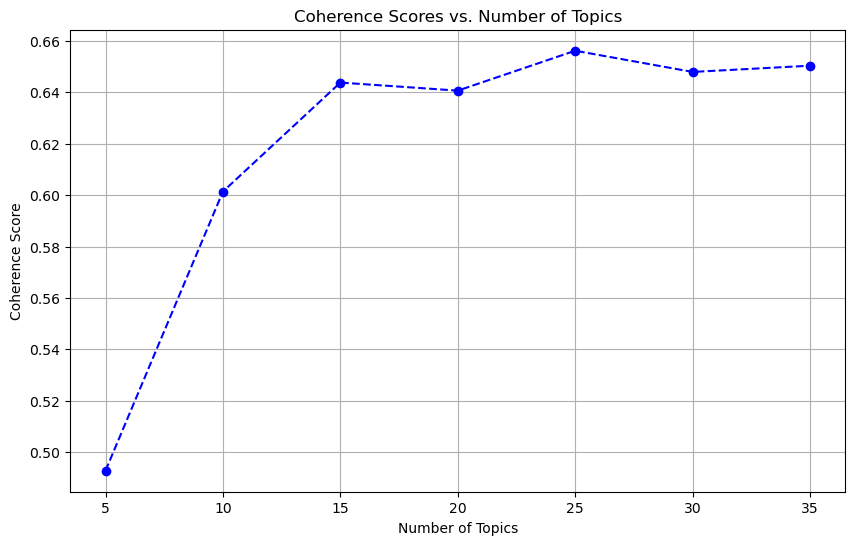

In [9]:
coherence_scores = []
for num_topics in range(5, 40, 5): 
    lda_model = gensim.models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=5, workers=2)
    coherence_model = CoherenceModel(model=lda_model, texts=clean_content, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(5, 40, 5), coherence_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores vs. Number of Topics")
plt.xticks(range(5, 40, 5))
plt.grid(True)
plt.show()


# Result:
### The best number of topis is 15 topics.
The best number of topis is 15 topics. Typically, as the number of topics rises, the coherence score tends to increase, yet this increment diminishes with higher topic counts. Balancing the number of topics against coherence score involves employing the elbow technique. This approach involves graphing coherence score against the number of topics and selecting the point of the curve where the elbow occurs. The rationale here is to pinpoint a stage where the incremental gain in coherence score from adding more topics becomes negligible, no longer justifying the further expansion of topic numbers. So the best number of topic will be 15.